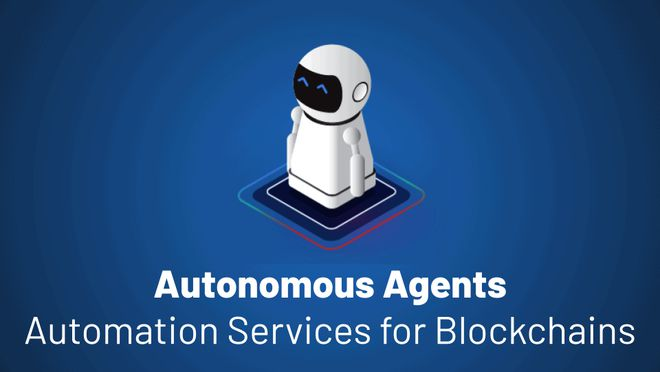
智能体的核心思想是使用语言模型来选择要执行的一系列操作。在链中，一系列操作是硬编码的（在代码中）。在代理中，语言模型用作推理引擎，以确定要采取哪些操作以及以何种顺序执行。

这里有几个关键组件：


### AgentAction 代理操作

这是一个数据类，表示代理应执行的操作。它有一个 tool 属性（应调用的工具的名称）和一个 tool_input 属性（该工具的输入）

### AgentFinish （代理完成）
这表示代理准备返回给用户时的最终结果。它包含一个 return_values 键值映射，其中包含最终的代理输出。通常，这包含一个 output 密钥，其中包含一个字符串，该字符串是代理的响应。

### Intermediate Steps 中间步骤
这些表示以前的代理操作和此当前代理运行的相应输出。这些对于传递到将来的迭代非常重要，这样代理就知道它已经完成了哪些工作。这被键入为 List[Tuple[AgentAction, Any]] .请注意，观察目前保留为类型 Any ，以最大限度地灵活。在实践中，这通常是一个字符串。


### Agent 代理

这是负责决定下一步采取什么步骤的链。这通常由语言模型、提示和输出解析器提供支持。

不同的智能体具有不同的推理提示风格、不同的输入编码方式以及不同的输出解析方式。有关内置代理的完整列表，请参阅代理类型。如果您需要进一步控制，您还可以轻松构建自定义代理。


### Agent Inputs 代理输入

代理的输入是键值映射。只有一个必需的键： intermediate_steps ，如 Intermediate Steps 上所述。

通常，PromptTemplate 负责将这些对转换为最好传递到 LLM.

### Agent Outputs 代理输出

输出是要执行的下一个操作或要发送给用户的最终响应（ AgentAction s 或 AgentFinish ）。具体来说，这可以键入为 Union[AgentAction, List[AgentAction], AgentFinish] 。

输出解析器负责获取原始LLM输出并将其转换为这三种类型之一。

### AgentExecutor 代理执行器

代理执行程序是代理的运行时。这实际上是调用代理，执行它选择的操作，将操作输出传递回代理，然后重复。在伪代码中，这大致如下所示：

```
next_action = agent.get_action(...)
while next_action != AgentFinish:
    observation = run(next_action)
    next_action = agent.get_action(..., next_action, observation)
return next_action
```


虽然这看起来很简单，但此运行时会为你处理一些复杂性，包括：

1. 处理代理选择不存在的工具的情况
2. 处理工具错误的情况
3. 处理代理生成无法解析为工具调用的输出的情况
4. 对 stdout 和/或 LangSmith 的所有级别（代理决策、工具调用）进行日志记录和可观察性。


### Tools 工具

工具是代理可以调用的功能。 Tool 抽象由两个组件组成：

1. 工具的输入方案。这说明了LLM调用该工具所需的参数。没有这个，它将不知道正确的输入是什么。这些参数应合理地命名和描述。
2. 要运行的函数。这通常只是一个被调用的 Python 函数。

如果不考虑两者，您将无法构建有效的代理。如果您不授予代理访问一组正确工具的权限，它将永远无法实现您为其提供的目标。如果你没有很好地描述这些工具，代理将不知道如何正确使用它们。

LangChain提供了广泛的内置工具，但也可以轻松定义自己的工具（包括自定义描述）。有关内置工具的完整列表，请参阅工具集成部分

对于许多常见任务，代理将需要一组相关工具。为此，LangChain提供了工具包的概念 - 完成特定目标所需的大约3-5个工具组。例如，GitHub 工具包具有用于搜索 GitHub 问题的工具、用于读取文件的工具、用于评论的工具等。
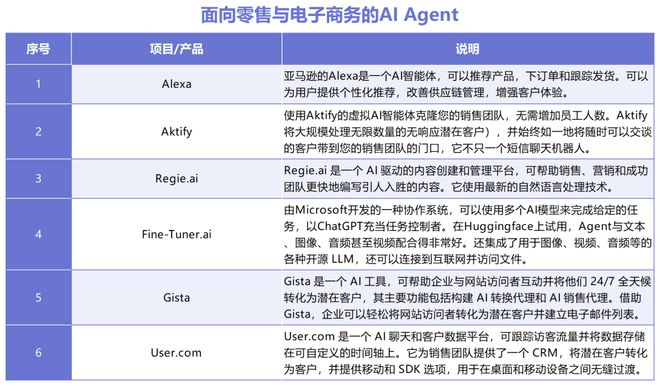


## Agent Types 代理类型

这会从几个维度对所有可用的代理进行分类。

### Intended Model Type 预期型号类型

此代理是用于聊天模型（接收消息，输出消息）还是LLMs（接收字符串，输出字符串）。这主要影响的是所使用的提示策略。您可以使用具有与预期模型类型不同的代理，但它可能不会产生相同质量的结果。

### Supports Chat History 支持聊天记录

这些代理类型是否支持聊天记录。如果是这样，这意味着它可以用作聊天机器人。如果没有，则意味着它更适合单个任务。支持聊天记录通常需要更好的模型，因此针对较差模型的早期代理类型可能不支持它。

### Supports Multi-Input Tools支持多输入工具
这些代理类型是否支持具有多个输入的工具。如果一个工具只需要一个输入，通常LLM更容易知道如何调用它。因此，针对较差模型的几种早期代理类型可能不支持它们。

### Supports Parallel Function Calling支持并行函数调用
同时LLM调用多个工具可以大大加快座席的速度，无论是否有任务可以通过这样做来辅助。但是，这样做更具挑战性LLMs，因此某些代理类型不支持此功能。

### Required Model Params 必需的模型参数
此代理是否要求模型支持任何其他参数。某些代理类型利用了 OpenAI 函数调用等需要其他模型参数的功能。如果不需要，则意味着一切都是通过提示完成的

